In [1]:
# Imports

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import os, os.path
from itertools import *
import math
import random
import scipy.stats
import sys
from joblib import Parallel, delayed
import multiprocessing
nproc = max(1, multiprocessing.cpu_count())
from scipy.sparse import csr_matrix
import scipy.sparse
from sklearn import cross_validation, base
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import ParameterGrid, GridSearchCV
from scipy.sparse.linalg import svds
import networkx as nx
import scipy
import time
    
# Warnings

import warnings
warnings.filterwarnings('ignore')

# Uncompress data

if not os.path.exists('data'):
    os.mkdir('data')

def have_data():
    return {'testTriplets.txt', 'txTripletsCounts.txt'}.issubset(set(os.listdir('data')))
if not have_data():
    ! cp Assignment3_Bitcoin/data.zip .

# Uncompress data

if not os.path.exists('data'):
    os.mkdir('data')

def have_data():
    return {'testTriplets.txt', 'txTripletsCounts.txt'}.issubset(set(os.listdir('data')))
if not have_data():
    ! cp Assignment3_Bitcoin/data.zip .
    ! unzip data.zip
    ! rm data.zip
    if not have_data():
        raise Exception('Error unpacking data')
    ! unzip data.zip
    ! rm data.zip
    if not have_data():
        raise Exception('Error unpacking data')
        
# Extract data in df form and as a sparse matrix

dftrain = pd.read_csv('data/txTripletsCounts.txt',
                      header=None,
                      index_col=None,
                      sep=' ',
                      names=['sender','receiver','transaction'])

dftest = pd.read_csv('data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])

dim = max(df[c].max() for df in (dftrain, dftest) for c in ['sender', 'receiver'])
dim += 1

# both the matrices here have m[i, j] return the number of transactions from i to j
# in training.
train_csr = csr_matrix((dftrain['transaction'],(dftrain['sender'],dftrain['receiver'])),
                       shape=(dim,dim),
                       dtype=float)

train_csc = train_csr.tocsc()

def maxlgbin(series): return math.ceil(np.log2(series.max()))

bincsr = train_csr.sign()
bincsc = train_csc.sign()
logcsr = train_csr.log1p()
logcsc = train_csc.log1p()

In [4]:
# As a NetworkX graph
G = nx.from_scipy_sparse_matrix(train_csr, parallel_edges=False, create_using=nx.DiGraph())

Exploratory data analysis

count    3.348026e+06
mean     4.725741e+00
std      1.284948e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.163900e+04
Name: transaction, dtype: float64


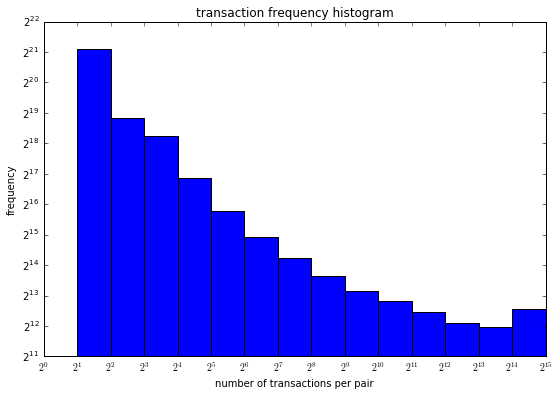

In [3]:
# Time data is not present. Thus, we'll be inferring probability of interaction
# as a stationary distribution over time, informed by the number of iteractions in the past.
series = dftrain['transaction']
title = 'transaction frequency histogram'
xlb = 'number of transactions per pair'
ylb = 'frequency'

print(series.describe())

bins = range(maxlgbin(series))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
plt.hist(series, bins=bins)
plt.gca().set_yscale('log', basey=2)
plt.title(title)
plt.xlabel(xlb)
plt.ylabel(ylb)
plt.show()

In [51]:
n_sender = dftrain['sender'].unique().size
n_receiver = dftrain['receiver'].unique().size
n_transactions = dftrain['transaction'].sum()
n_nonmissing = dftrain['transaction'].count()
sparsity = 1 - n_nonmissing*1.0/n_sender/n_receiver
for i in ['n_sender', 'n_receiver', 'n_transactions', 'n_nonmissing', 'sparsity']: print(i, eval(i))
print('num edges', len(dftrain))

n_sender 443652
n_receiver 439602
n_transactions 15821903
n_nonmissing 3348026
sparsity 0.999982833304
num edges 3348026


count    444075.000000
mean          7.539326
std         316.680366
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max      172727.000000
dtype: float64
count    444075.000000
mean          7.539326
std         369.349803
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max      164333.000000
dtype: float64


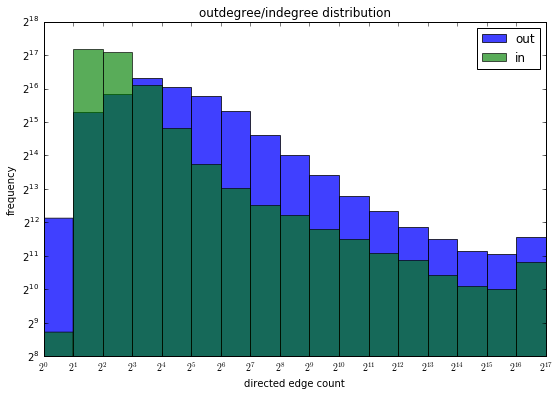

In [6]:
# Direction of edges is sender -> receiver
send_distribution = pd.Series(np.squeeze(np.asarray(bincsr.sum(0))))
recv_distribution = pd.Series(np.squeeze(np.asarray(bincsc.sum(1))))
title = 'outdegree/indegree distribution'
xlb = 'directed edge count'
ylb = 'frequency'

print(send_distribution.describe())
print(recv_distribution.describe())

# http://stackoverflow.com/questions/7694298/how-to-make-a-log-log-histogram-in-python
bins = range(max(maxlgbin(x) for x in (send_distribution, recv_distribution)))
plt.figure(figsize=(9,6))
plt.axes().set_aspect(9/6)
plt.xticks(bins, [r'$2^{{{}}}$'.format(i) for i in bins])
plt.hist(send_distribution, bins=bins, label='out', alpha=0.75)
plt.hist(recv_distribution, bins=bins, label='in', alpha=0.65)
plt.legend()
#plt.legend()#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().set_yscale('log', basey=2)
plt.title(title)
plt.xlabel(xlb)
plt.ylabel(ylb)
plt.show()

In [7]:
# Get the SCCs (memoized)
sccs = None
try:
    with open('train_sccs.p', 'rb') as infile:
        sccs = pickle.load(infile)
except FileNotFoundError:
    print('SCC file missing, recreating SCCs')
    # This takes <1hr on cycles
    sccs = list(nx.strongly_connected_components(G))
    with open('train_sccs.p', 'wb') as outfile:
        pickle.dump(sccs, outfile)

In [8]:
print('# sccs', len(sccs))
series = pd.Series(sorted([len(scc) for scc in sccs]))
title = 'SCC size distribution'
xlb = 'scc sizes'
ylb = 'frequency'
print(series.describe())
for q in [0.9, 0.99, 0.999, 0.9999, 0.99999, 0.999999]:
    print('quantile', q, series.quantile(q))

# sccs 9254
count      9254.000000
mean         47.987357
std        4508.165332
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max      433676.000000
dtype: float64
quantile 0.9 1.0
quantile 0.99 2.0
quantile 0.999 9.747
quantile 0.9999 32866.5748997
quantile 0.99999 393595.05749
quantile 0.999999 429667.905749


In [16]:
import os
os.environ['OMP_NUM_THREADS'] = str(max(nproc // 4, 1))
old_flags = os.environ.get('THEANO_FLAGS', '')
if 'openmp' not in old_flags:
    os.environ['THEANO_FLAGS'] = old_flags + ',openmp=true' + ',openmp_elemwise_minsize=1000'

import theano, theano.sparse
print('openmp', theano.config.openmp, 'nthreads', nproc)

from sklearn.preprocessing import normalize
import random

# (Takes and Kosters 2013) http://www.mdpi.com/1999-4893/6/1/100/htm
# Sample a distribution (only need about 0.1) for these metrics for each vertex
nrows = 1000
sample = random.sample(range(dim), nrows)

def timeddot(x, desc):
    t = time.time()
    y = f(x)
    print(desc, '{}K rows time'.format(nrows // 1000), time.time() - t)
    return y

x = theano.sparse.csr_matrix(name='x', dtype='float64')
y = theano.sparse.dot(x[sample], x.T)
f = theano.function([x], y)
[dotprod, binprod, logprod] = [timeddot(*x) for x in [
    (train_csr, 'regular'),
    (train_csr.sign(), 'binary'),
    (train_csr.log1p(), 'log1p')]]

openmp True nthreads 38
regular 1K rows time 2.978071689605713
binary 1K rows time 2.773721933364868
log1p 1K rows time 2.7553088665008545


In [21]:
# min data contribution
for x in ['dot', 'bin', 'log']:
    mat = eval(x + 'prod')
    data = mat.reshape(mat.size)
    print(x, 'zeros', (mat == 0).sum().sum() / mat.size)
    print(x, '(mean - median) / std', (data.mean() - np.median(data)) / data.std())
    print(x, '(99th - mean) / std', (np.percentile(data, 99) - data.mean()) / data.std())

dot zeros 0.792183604121
dot (mean - median) / std 0.0288356934379
dot (99th - mean) / std 0.178112019138
bin zeros 0.792183604121
bin (mean - median) / std 0.412398829038
bin (99th - mean) / std 1.47357872844
log zeros 0.792183604121
log (mean - median) / std 0.377840016456
log (99th - mean) / std 2.61382453177


In [66]:
# Can probably run simrank on full dot product, but no time for custom low-value-removal.

In [24]:
# Just check we never get a repeat sender
sum(train_csr[row['sender'], row['receiver']] for index, row in dftest.iterrows())

0.0

In [21]:
# Create a simple CV scheme (relying on our time-stationarity assumption)
# for evaluation.

Xtrain = dftrain[['sender', 'receiver']].values.astype('int')
Ytrain = dftrain['transaction'].values.astype('bool')
Xtest = dftest[['sender', 'receiver']].values.astype('int')
Ytest = dftest['transaction'].values.astype('bool')
iX = np.arange(len(Xtrain))
n_ones = Ytest.sum()
n_zeros = len(Ytest) - n_ones

n_folds = 10
cv = list(islice(cross_validation.KFold(
    len(Ytrain), n_folds=(len(Xtrain) // n_ones), shuffle=True, random_state=0), 0, n_folds))

In [32]:
def named_matrix(A):
    if A == 'counts': return train_csr
    elif A == 'binary': return bincsr
    elif A == 'log1p': return logcsr
    return None

def masked_matrix(A, iX):
    M = named_matrix(A)
    mask = np.ones(len(Xtrain), dtype='bool')
    mask[iX] = 0
    X = Xtrain[mask]
    vals = np.ones(len(X))
    X = X.transpose()
    disable = csr_matrix((vals, (X[0], X[1])), shape=M.shape)    
    return M - M.multiply(disable)

def AUC(exact, pred):
    fpr, tpr, thresholds = roc_curve(exact, pred)
    return auc(fpr, tpr)

def sample_one():
    while True:
        i, j = (random.randint(0, dim - 1) for i in range(2))
        if i == j: continue
        if not bincsr[i, j]: return [i, j]

class CachedTrainingMatrixEstimator(base.BaseEstimator):
    def __init__(self):
        super(CachedTrainingMatrixEstimator, self).__init__()
    
    def score(self, iX, Y):
        assert abs(len(Y) - n_ones) <= 1
        assert np.all(Y > 0)
        assert len(iX) == len(Y)
        yes_train = Xtrain[iX]
        no_train = np.array([sample_one() for i in range(n_zeros)])
        pred_yes = self.predict(yes_train)
        pred_no = self.predict(no_train)
        exact_yes = np.ones(len(pred_yes), dtype='int')
        exact_no = np.zeros(len(pred_no), dtype='int')
        exact = np.concatenate((exact_yes, exact_no))
        pred = np.concatenate((pred_yes, pred_no))
        return AUC(exact, pred)

def cvAUC(estimator, grid, name, verbosity=0):
    print('Running grid search for {}'.format(name))
    gse = GridSearchCV(estimator, grid, n_jobs=nproc, verbose=verbosity, cv=cv)
    t = time.time()
    gse.fit(iX, Ytrain)
    t = int(time.time() - t)
    print('\tran cv grid with best AUC {:.4f} in {} s '.format(gse.best_score_, t))
    print('\tmodel:', gse.best_params_)
    return gse.best_estimator_

def eval_fold(estimator_class, cvfold, param):
    param_key = str(sorted(param.items()))    
    est = estimator_class(**param)
    train_ix, test_ix = cvfold
    print(' ' + param_key + '\n', end='')
    sys.stdout.flush()
    est.fit(iX[train_ix], Ytrain[train_ix])
    return param_key, (est.score(iX[test_ix], Ytrain[test_ix]), len(test_ix), param)

def conglomerate_cvs(cvs):
    full_dict = {}
    for key, (auc, n, param) in cvs:
        totauc, tot, param = full_dict.get(key, (0, 0, param))
        full_dict[key] = totauc + auc * n, tot + n, param
    return max((a / n, param) for k, (a, n, param) in full_dict.items())

def cvAUC_broken(estimator_class, grid, name):
    print('Running grid search for {}'.format(name))
    cv_params = product(cv, ParameterGrid(grid))
    t = time.time()
    all_cv = Parallel(n_jobs=nproc)(
        delayed(eval_fold)(estimator_class, cv, p) for cv, p in cv_params)
    t = int(time.time() - t)
    best_auc, best_p = conglomerate_cvs(all_cv)
    print('\tran cv grid with best AUC {:.4f} in {} s '.format(best_auc, t))
    print('\tmodel:', best_p)
    est = estimator_class(**best_p)
    est.fit(iX, Ytrain)
    return est

In [23]:
class SVDFactorization(CachedTrainingMatrixEstimator):
    def __init__(self, A, k):
        super(SVDFactorization, self).__init__()
        self.A = A
        self.k = k
        
    def fit(self, iX, y):
        X = masked_matrix(self.A, iX)
        self.u, self.s, self.vt = svds(X, k=self.k, tol=1e-10, which='LM')
        
    def predict(self, X):
        senders, receivers = X[:, 0], X[:, 1]
        sv = self.s[:, np.newaxis] * self.vt[:, receivers]
        u = self.u[senders, :]
        return (u * sv.transpose()).sum(axis=1)
        
grid = {
    'A': ['binary'], # ['counts', 'binary', 'log1p'],
    'k': [4]} #list(range(1, 21))}

# Full grid commented out for speed, result same as below.

svd = cvAUC(SVDFactorization(None, None), grid, 'SVD', verbosity=1)

Running grid search for SVD
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=48)]: Done  10 out of  10 | elapsed:   39.3s finished


	ran cv grid with best AUC 0.8542 in 51 s 
	model: {'k': 4, 'A': 'binary'}


In [64]:
def logistic(x): return 1 / (1 + math.exp(-x))

vlogistic = np.vectorize(logistic)

class NormalizedSVD(SVDFactorization):
    def __init__(self, A, k):
        super(NormalizedSVD, self).__init__(A, k)
        
    def fit(self, iX, y):
        super(NormalizedSVD, self).fit(iX, y)
        
    def predict(self, X):
        return vlogistic(super(NormalizedSVD, self).predict(X))
        
grid = {
    'A': ['log1p'], # ['counts', 'binary', 'log1p'],
    'k': [4]} #list(range(1, 21))}

# Full grid commented out for speed, result same as below.

nsvd = cvAUC(NormalizedSVD(None, None), grid, 'normalized SVD', verbosity=1)

Running grid search for normalized SVD
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=48)]: Done  10 out of  10 | elapsed:   21.2s finished


	ran cv grid with best AUC 0.7967 in 27 s 
	model: {'k': 4, 'A': 'log1p'}


In [34]:
def make_NMF(M, n_components, alpha, l1_ratio, init):
    from sklearn.decomposition import NMF
    nmf = NMF(n_components=n_components, init=init, alpha=alpha, l1_ratio=l1_ratio)
    W = nmf.fit_transform(M)
    return W, nmf.components_

class NMFPredictor(CachedTrainingMatrixEstimator):
    def __init__(self, A, n_components, alpha, l1_ratio, init):
        super(NMFPredictor, self).__init__()
        self.A = A
        self.args = (n_components, alpha, l1_ratio, init)
        
    def fit(self, iX, y):
        X = masked_matrix(self.A, iX)
        self.W, self.H = make_NMF(X, *self.args)
        
    def predict(self, X):
        senders, receivers = X[:, 0], X[:, 1]
        return (self.W[senders, :] * self.H.transpose()[receivers, :]).sum(axis=1)
           
grid = {
    'A': ['counts'], #['counts', 'binary', 'log1p'],
    'n_components': [4], # list(range(1, 21))
    'alpha': [0], #[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0], #np.arange(0, 1.01, .1),
    'init': ['nndsvd']} #['random', 'nndsvd','nndsvda']}

# Full grid commented out for speed, result same as belo

#Running grid search for NMF
#        created 693 size grid in 3382 s
#        ran cv with AUC 0.7496 in 1804 s 
#        model: {'init': 'random', 'n_components': 4, 'A': 'binary', 'alpha': 10, 'l1_ratio': 0.0}

cvAUC_broken(NMFPredictor, grid, 'NMF')

Running grid search for NMF
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
 [('A', 'counts'), ('alpha', 0), ('init', 'nndsvd'), ('l1_ratio', 0), ('n_components', 4)]
	ran cv grid with best AUC 0.8021 in 30 s 
	model: {'init': 'n

NMFPredictor(A='counts', alpha=None, init=None, l1_ratio=None,
       n_components=None)

In [3]:
# Clustering: will use Adamic-Adar as score, prune low-score edges
# Offers a coarser clustering (and thus potentially a more generalizing factorization)
# by deleting "tenuous" edges, smarter prediction on the cluster (Liben-Nowell and Kleninberg 2007).

# first, turning into binary undirected graph
sym_csr = (train_csr + train_csr.transpose()).sign()
simple_graph = nx.from_scipy_sparse_matrix(sym_csr)

In [37]:
%timeit nx.adamic_adar_index(simple_graph, simple_graph.edges()[:10])

1 loop, best of 3: 3.21 s per loop


In [4]:
n_edges = len(simple_graph.edges())
mins = 3.21 / 10 * n_edges / 60
tot_cycles_cpus = 38 * 4
print('single thread days', mins / 60 / 24,
      'full cycles ({} cpus) mins'.format(tot_cycles_cpus),
      mins / tot_cycles_cpus)
# still feasible to do if we use all of cycles

single thread days 10.348850520833333 full cycles (152 cpus) mins 98.04174177631579


In [43]:
# see adamic-adar directory for details
# with open('data/simple_graph.p', 'wb') as r: pickle.dump(simple_graph, r)
n_edges = 2785485
offsets = [0, 696371, 1392742, 2089113, 2785485]
contents = os.listdir('adamic-adar')

pairs = list(zip(*(offsets, offsets[1:])))
files = ['{}-{}.p'.format(i, j) for i, j in pairs]
print(files)
for f in files:
    assert f in contents

def get_weights(f, i, j):
    with open('adamic-adar/' + f, 'rb') as r:
        return pickle.load(r)[:j-i]

all_edges = list(chain.from_iterable(
        get_weights(f, i, j) for f, (i, j) in zip(files, pairs)))

assert len(all_edges) == n_edges
all_edges.sort(key=lambda x: x[2])
weights = np.array([x[2] for x in all_edges])

['0-696371.p', '696371-1392742.p', '1392742-2089113.p', '2089113-2785485.p']


mean 3.15233383513 std 41.3895184548


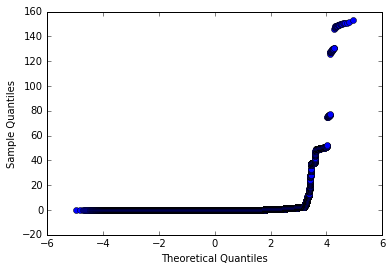

In [37]:
import statsmodels.graphics.gofplots
mu = weights.mean()
std = weights.std()
print('mean', mu, 'std', std)
whitened = (weights - mu) / std
statsmodels.graphics.gofplots.qqplot(whitened)
pass

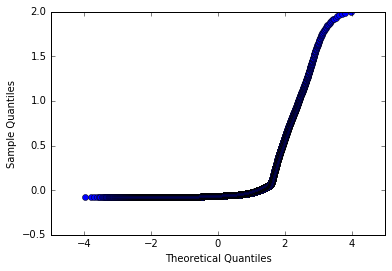

In [39]:
x = whitened[whitened < 2]
statsmodels.graphics.gofplots.qqplot(x[range(0, len(x), 100)])
pass

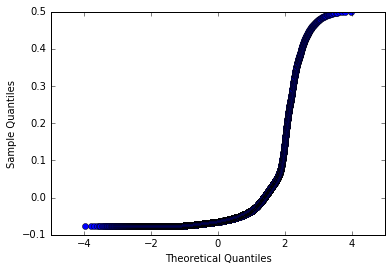

In [40]:
x = whitened[whitened < 0.5]
statsmodels.graphics.gofplots.qqplot(x[range(0, len(x), 100)])
pass

In [ ]:
n_dropped = n_edges // 10
edges_to_drop = {(i, j) for i, j, k in all_edges[n_dropped:]}
edges_to_drop.update({(j, i) for i, j in edges_to_drop})

filt = ~dftrain[['sender', 'receiver']].apply(lambda x: tuple(x), axis=1).isin(edges_to_drop)

In [ ]:
restricted = dftrain.loc[filt]

# both the matrices here have m[i, j] return the number of transactions from i to j
# in training.
train_csr = csr_matrix((restricted['transaction'],(restricted['sender'], restricted['receiver'])),
                       shape=(dim,dim),
                       dtype=float)

train_csc = train_csr.tocsc()
bincsr = train_csr.sign()
bincsc = train_csc.sign()
logcsr = train_csr.log1p()
logcsc = train_csc.log1p()

# Create a simple CV scheme (relying on our time-stationarity assumption)
# for evaluation.

Xtrain = dftrain[['sender', 'receiver']].values.astype('int')
Ytrain = dftrain['transaction'].values.astype('bool')
Xtest = dftest[['sender', 'receiver']].values.astype('int')
Ytest = dftest['transaction'].values.astype('bool')
iX = np.arange(len(Xtrain))
n_ones = Ytest.sum()
n_zeros = len(Ytest) - n_ones

n_folds = 10
cv = list(islice(cross_validation.KFold(
    len(Ytrain), n_folds=(len(Xtrain) // n_ones), shuffle=True, random_state=0), 0, n_folds))

def named_matrix(A):
    if A == 'counts': return train_csr
    elif A == 'binary': return bincsr
    elif A == 'log1p': return logcsr
    return None

def masked_matrix(A, iX):
    M = named_matrix(A)
    mask = np.ones(len(Xtrain), dtype='bool')
    mask[iX] = 0
    X = Xtrain[mask]
    vals = np.ones(len(X))
    X = X.transpose()
    disable = csr_matrix((vals, (X[0], X[1])), shape=M.shape)    
    return M - M.multiply(disable)

def AUC(exact, pred):
    fpr, tpr, thresholds = roc_curve(exact, pred)
    return auc(fpr, tpr)

def sample_one():
    while True:
        i, j = (random.randint(0, dim - 1) for i in range(2))
        if i == j: continue
        if not bincsr[i, j]: return [i, j]

class CachedTrainingMatrixEstimator(base.BaseEstimator):
    def __init__(self):
        super(CachedTrainingMatrixEstimator, self).__init__()
    
    def score(self, iX, Y):
        assert abs(len(Y) - n_ones) <= 1
        assert np.all(Y > 0)
        assert len(iX) == len(Y)
        yes_train = Xtrain[iX]
        no_train = np.array([sample_one() for i in range(n_zeros)])
        pred_yes = self.predict(yes_train)
        pred_no = self.predict(no_train)
        exact_yes = np.ones(len(pred_yes), dtype='int')
        exact_no = np.zeros(len(pred_no), dtype='int')
        exact = np.concatenate((exact_yes, exact_no))
        pred = np.concatenate((pred_yes, pred_no))
        return AUC(exact, pred)

def cvAUC(estimator, grid, name, verbosity=0):
    print('Running grid search for {}'.format(name))
    gse = GridSearchCV(estimator, grid, n_jobs=nproc, verbose=verbosity, cv=cv)
    t = time.time()
    gse.fit(iX, Ytrain)
    t = int(time.time() - t)
    print('\tran cv grid with best AUC {:.4f} in {} s '.format(gse.best_score_, t))
    print('\tmodel:', gse.best_params_)
    return gse.best_estimator_

def eval_fold(estimator_class, cvfold, param):
    param_key = str(sorted(param.items()))    
    est = estimator_class(**param)
    train_ix, test_ix = cvfold
    print(' ' + param_key + '\n', end='')
    sys.stdout.flush()
    est.fit(iX[train_ix], Ytrain[train_ix])
    return param_key, (est.score(iX[test_ix], Ytrain[test_ix]), len(test_ix), param)

def conglomerate_cvs(cvs):
    full_dict = {}
    for key, (auc, n, param) in cvs:
        totauc, tot, param = full_dict.get(key, (0, 0, param))
        full_dict[key] = totauc + auc * n, tot + n, param
    return max((a / n, param) for k, (a, n, param) in full_dict.items())

def cvAUC_broken(estimator_class, grid, name):
    print('Running grid search for {}'.format(name))
    cv_params = product(cv, ParameterGrid(grid))
    t = time.time()
    all_cv = Parallel(n_jobs=nproc)(
        delayed(eval_fold)(estimator_class, cv, p) for cv, p in cv_params)
    t = int(time.time() - t)
    best_auc, best_p = conglomerate_cvs(all_cv)
    print('\tran cv grid with best AUC {:.4f} in {} s '.format(best_auc, t))
    print('\tmodel:', best_p)
    est = estimator_class(**best_p)
    est.fit(iX, Ytrain)
    return est

class SVDFactorization(CachedTrainingMatrixEstimator):
    def __init__(self, A, k):
        super(SVDFactorization, self).__init__()
        self.A = A
        self.k = k
        
    def fit(self, iX, y):
        X = masked_matrix(self.A, iX)
        self.u, self.s, self.vt = svds(X, k=self.k, tol=1e-10, which='LM')
        
    def predict(self, X):
        senders, receivers = X[:, 0], X[:, 1]
        sv = self.s[:, np.newaxis] * self.vt[:, receivers]
        u = self.u[senders, :]
        return (u * sv.transpose()).sum(axis=1)
        
grid = {
    'A': ['binary'], # ['counts', 'binary', 'log1p'],
    'k': list(range(1, 21))}

svd = cvAUC(SVDFactorization(None, None), grid, 'SVD', verbosity=1)

In [24]:
# Get an AUC on test perf basline with jaccard
def sender(row): return bincsr.getrow(int(row['sender']))
def receiver(row): return bincsc.getcol(int(row['receiver']))
def jaccard(row):
    a = sender(row)
    b = receiver(row)
    union = a + b.transpose()
    union = union.sign()
    usize = union.dot(union.transpose())[0, 0]
    return 0 if usize == 0 else a.dot(b)[0, 0] / usize
pred = [jaccard(row) for index,row in dftest.iterrows()]
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print('in-out jaccard auc', roc_auc)

in-out jaccard auc 0.6396775
